In [ ]:
!pip install nibabel -q
!pip install scikit-learn -q
!pip install tifffile -q
!pip install tqdm -q
!pip install split-folders -q

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import random
import splitfolders
from tqdm import tqdm
import nibabel as nib
import glob
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import shutil
import time

from dataclasses import dataclass
import gc


import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
def seed_everything(SEED):
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def get_default_device():
    gpu_available = torch.cuda.is_available()
    return torch.device('cuda' if gpu_available else 'cpu'), gpu_available

In [ ]:
scaler = MinMaxScaler()

DATASET_PATH = "/content/drive/MyDrive/data/train"
print("Total Files: ", len(os.listdir(DATASET_PATH)))

Total Files:  50


In [ ]:
!ls /content/drive/MyDrive/data/train/BraTS20_Training_001

BraTS20_Training_001_flair.nii	BraTS20_Training_001_t1.nii
BraTS20_Training_001_seg.nii	BraTS20_Training_001_t2.nii
BraTS20_Training_001_t1ce.nii


In [ ]:
# Load the NIfTI image
sample_image_flair = nib.load(os.path.join(DATASET_PATH , "BraTS20_Training_001/BraTS20_Training_001_flair.nii")).get_fdata()
print("Original max value:", sample_image_flair.max())

# Reshape the 3D image to 2D for scaling
sample_image_flair_flat = sample_image_flair.reshape(-1, 1)

Original max value: 625.0


In [ ]:
# Apply scaling
sample_image_flair_scaled = scaler.fit_transform(sample_image_flair_flat)

# Reshape it back to the original 3D shape
sample_image_flair_scaled = sample_image_flair_scaled.reshape(sample_image_flair.shape)

print("Scaled max value:", sample_image_flair_scaled.max())
print("Shape of scaled Image: ", sample_image_flair_scaled.shape)

Scaled max value: 1.0
Shape of scaled Image:  (240, 240, 155)


In [ ]:
sample_image_t1 = nib.load(DATASET_PATH + '/BraTS20_Training_001/BraTS20_Training_001_t1.nii').get_fdata()
sample_image_t1 = scaler.fit_transform(sample_image_t1.reshape(-1,sample_image_t1.shape[-1])).reshape(sample_image_t1.shape)
sample_image_t1.shape

(240, 240, 155)

In [ ]:
sample_image_t1ce = nib.load(DATASET_PATH + '/BraTS20_Training_001/BraTS20_Training_001_t1ce.nii').get_fdata()
sample_image_t1ce = scaler.fit_transform(sample_image_t1ce.reshape(-1,sample_image_t1ce.shape[-1])).reshape(sample_image_t1ce.shape)
sample_image_t1ce.shape

(240, 240, 155)

In [ ]:
sample_image_t2 = nib.load(DATASET_PATH + '/BraTS20_Training_001/BraTS20_Training_001_t2.nii').get_fdata()
sample_image_t2 = scaler.fit_transform(sample_image_t2.reshape(-1,sample_image_t2.shape[-1])).reshape(sample_image_t2.shape)
sample_image_t2.shape

(240, 240, 155)

In [ ]:
sample_mask = nib.load(DATASET_PATH + '/BraTS20_Training_001/BraTS20_Training_001_seg.nii').get_fdata()
sample_mask = sample_mask.astype(np.uint8)  #values between 0 and 255

print("Unique class in the mask", np.unique(sample_mask))

# Class 3 doesn't exist in the mask, so we will reassign class 4 to class 3
# sample_mask[sample_mask == 4] =3
# print("Unique class in the mask after reassign: ", np.unique(sample_mask))
print("Shape of mask: ", sample_mask.shape)

Unique class in the mask [0 1 2 4]
Shape of mask:  (240, 240, 155)


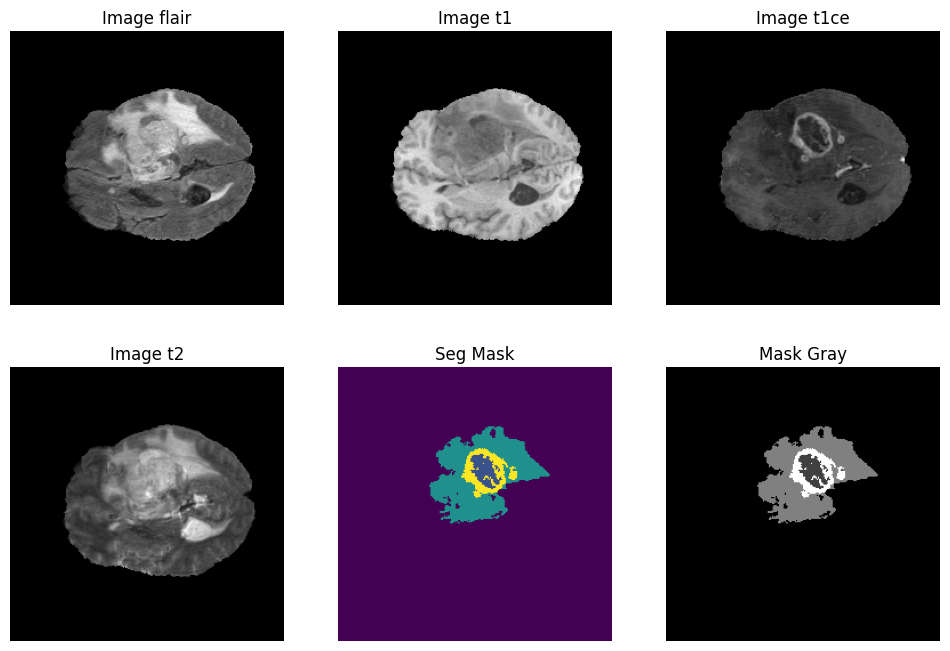

In [ ]:
n_slice = 70  # Use consistent slice number

plt.figure(figsize=(12, 8))

plt.subplot(231)
plt.imshow(sample_image_flair_scaled[:, :, n_slice], cmap='gray')
plt.title('Image flair')
plt.axis('off')  # Remove axis

plt.subplot(232)
plt.imshow(sample_image_t1[:, :, n_slice], cmap='gray')
plt.title("Image t1")
plt.axis('off')  # Remove axis

plt.subplot(233)
plt.imshow(sample_image_t1ce[:, :, n_slice], cmap='gray')
plt.title("Image t1ce")
plt.axis('off')  # Remove axis

plt.subplot(234)
plt.imshow(sample_image_t2[:, :, n_slice], cmap='gray')
plt.title("Image t2")
plt.axis('off')  # Remove axis

plt.subplot(235)
plt.imshow(sample_mask[:, :, n_slice])
plt.title("Seg Mask")
plt.axis('off')  # Remove axis

plt.subplot(236)
plt.imshow(sample_mask[:, :, n_slice], cmap='gray')
plt.title('Mask Gray')
plt.axis('off')  # Remove axis

# Save without padding and axes
plt.savefig("gt_plot.png", bbox_inches='tight', pad_inches=0)
plt.show()

In [ ]:
combined_x = np.stack([sample_image_flair_scaled, sample_image_t1ce, sample_image_t2], axis = 3) #along the last channel dimension.
print("Shape of Combined x ", combined_x.shape)

Shape of Combined x  (240, 240, 155, 3)


In [ ]:
combined_x = combined_x[56:184, 56:184, 13:141]
print("Shape after cropping: ", combined_x.shape)

sample_mask_c = sample_mask[56:184,56:184, 13:141]
print("Mask shape after cropping: ", sample_mask_c.shape)

# Assuming sample_mask_ is a NumPy array
size_in_bytes = sample_mask_c.nbytes
size_in_mb = size_in_bytes / (1024 ** 2)  # Convert from bytes to megabytes
print("\n")
print(f"Size of sample_mask_ in MB: {size_in_mb:.2f} MB")

Shape after cropping:  (128, 128, 128, 3)
Mask shape after cropping:  (128, 128, 128)


Size of sample_mask_ in MB: 2.00 MB


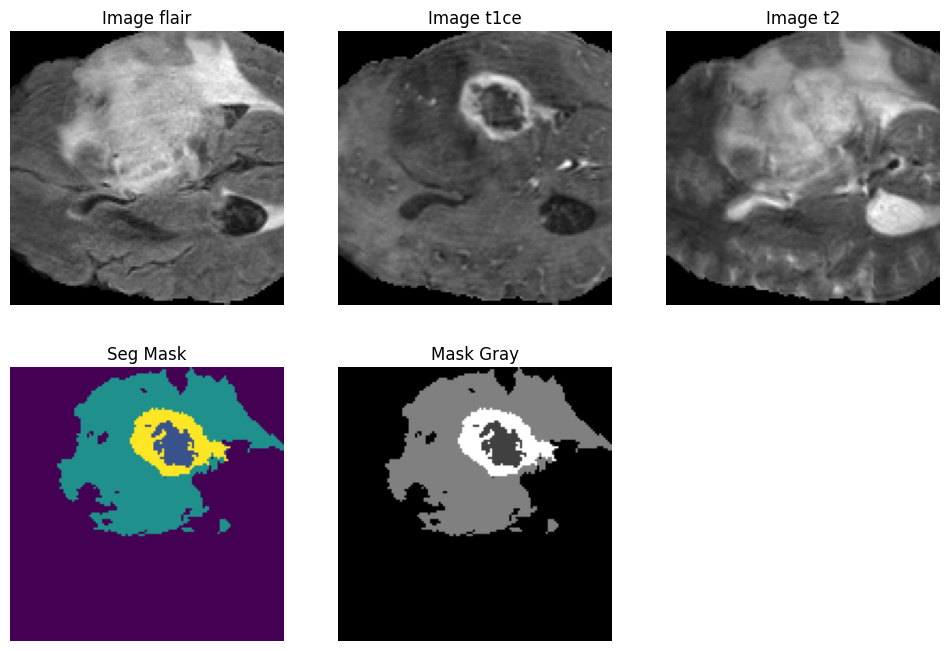

In [ ]:
import matplotlib.pyplot as plt
import random

# Randomly select a slice
n_slice = 60 # Ensure slice is within valid range

plt.figure(figsize=(12, 8))

# Display 'Image flair'
plt.subplot(231)
plt.imshow(combined_x[:, :, n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.axis('off')  # Remove axis

# Display 'Image t1ce'
plt.subplot(232)
plt.imshow(combined_x[:, :, n_slice, 1], cmap='gray')
plt.title("Image t1ce")
plt.axis('off')  # Remove axis

# Display 'Image t2'
plt.subplot(233)
plt.imshow(combined_x[:, :, n_slice, 2], cmap='gray')
plt.title("Image t2")
plt.axis('off')  # Remove axis

# Display segmentation mask without gray scale
plt.subplot(234)
plt.imshow(sample_mask_c[:, :, n_slice])
plt.title("Seg Mask")
plt.axis('off')  # Remove axis

# Display segmentation mask in gray scale
plt.subplot(235)
plt.imshow(sample_mask_c[:, :, n_slice], cmap='gray')
plt.title('Mask Gray')
plt.axis('off')  # Remove axis

# Save the figure without padding and axes
plt.savefig("gt_plot.png", bbox_inches='tight', pad_inches=0)
plt.show()

In [ ]:
os.makedirs("cropped_data", exist_ok = True)
np.save("cropped_data/combined255.npy", combined_x)

In [ ]:
my_img = np.load("cropped_data/combined255.npy")
my_img.shape

(128, 128, 128, 3)

In [ ]:
# Class 3 doesn't exist in the mask, so we will reassign class 4 to class 3
sample_mask_c[sample_mask_c == 4] = 3

sample_mask_cat  = F.one_hot(torch.tensor(sample_mask_c, dtype = torch.long), num_classes = 4) #0,1,2,3  -> dtype = torch.long as F.one_hot expects in int64
#If the tensor is not of integer type (e.g., float32 or uint8), it will raise an error because one-hot encoding cannot work with non-integer values.

In [ ]:
sample_mask_cat.shape #Got converted to categorical

torch.Size([128, 128, 128, 4])

In [ ]:
t1ce_list = sorted(glob.glob(f"{DATASET_PATH}/*/*t1ce.nii"))
t2_list = sorted(glob.glob(f"{DATASET_PATH}/*/*t2.nii"))
flair_list = sorted(glob.glob(f"{DATASET_PATH}/*/*t2.nii"))
mask_list = sorted(glob.glob(f"{DATASET_PATH}/*/*seg.nii"))

In [ ]:
print("t1ce list: ", len(t1ce_list))
print("t2 list: ", len(t2_list))
print("flair list: ", len(flair_list))
print("Mask list: ", len(mask_list))

t1ce list:  50
t2 list:  50
flair list:  50
Mask list:  50


In [ ]:
for idx in tqdm(range(len(t2_list)), desc = "Preparing to stack, crop and save", unit = "file" ):

    temp_image_t1ce = nib.load(t1ce_list[idx]).get_fdata()
    temp_image_t1ce = scaler.fit_transform(temp_image_t1ce.reshape(-1, temp_image_t1ce.shape[-1])).reshape(temp_image_t1ce.shape)

    temp_image_t2 = nib.load(t2_list[idx]).get_fdata()
    temp_image_t2 = scaler.fit_transform(temp_image_t2.reshape(-1, temp_image_t2.shape[-1])).reshape(temp_image_t2.shape)

    temp_image_flair = nib.load(flair_list[idx]).get_fdata()
    temp_image_flair = scaler.fit_transform(temp_image_flair.reshape(-1, temp_image_flair.shape[-1])).reshape(temp_image_flair.shape)

    temp_mask = nib.load(mask_list[idx]).get_fdata()
#     temp_mask = temp_mask.astype(np.uint8)
    temp_mask[temp_mask==4] = 3

    temp_combined_images = np.stack([temp_image_flair, temp_image_t1ce, temp_image_t2], axis = 3)

    temp_combined_images = temp_combined_images[56:184, 56:184, 13:141]
    temp_mask = temp_mask[56:184, 56:184, 13:141]

    val, counts = np.unique(temp_mask, return_counts = True)

    # If a volume has less than 1% of mask, we simply ignore to reduce computation
    if (1 - (counts[0]/counts.sum())) > 0.01:
#         print("Saving Processed Images and Masks")
        temp_mask = F.one_hot(torch.tensor(temp_mask, dtype = torch.long), num_classes = 4)
        os.makedirs("BraTS2020_Preprocessed/input_data_3channels/images", exist_ok = True)
        os.makedirs("BraTS2020_Preprocessed/input_data_3channels/masks", exist_ok = True)
        np.save("BraTS2020_Preprocessed/input_data_3channels/images/image_"+str(idx)+'.npy', temp_combined_images)
        np.save('BraTS2020_Preprocessed/input_data_3channels/masks/mask_'+ str(idx)+'.npy', temp_mask)

    else:
        pass

Preparing to stack, crop and save: 100%|██████████| 50/50 [04:51<00:00,  5.82s/file]


In [ ]:
!du -sh --block-size=G "BraTS2020_Preprocessed/input_data_3channels/images"

3G	BraTS2020_Preprocessed/input_data_3channels/images


In [ ]:
!du -sh --block-size=G "BraTS2020_Preprocessed/input_data_3channels/masks"

3G	BraTS2020_Preprocessed/input_data_3channels/masks


In [ ]:
images_folder = "BraTS2020_Preprocessed/input_data_3channels/images"
print(len(os.listdir(images_folder)))

masks_folder = "BraTS2020_Preprocessed/input_data_3channels/masks"
print(len(os.listdir(masks_folder)))

46
46


In [ ]:
input_folder = "BraTS2020_Preprocessed/input_data_3channels/"

output_folder = "BraTS2020_Preprocessed/input_data_128/"

# Adjusted ratios to sum to 1.0 (train, val, test)
splitfolders.ratio(input_folder, output_folder, seed=42, ratio=(0.75, 0.205, 0.045), group_prefix=None)

if os.path.exists(input_folder):
    shutil.rmtree(input_folder)
    print(f"{input_folder} is removed")
else:
    print(f"{input_folder} doesn't exist")

Copying files: 92 files [00:55,  1.66 files/s]


BraTS2020_Preprocessed/input_data_3channels/ is removed


In [ ]:
!du -sh --block-size=G "BraTS2020_Preprocessed"

6G	BraTS2020_Preprocessed
